# Modelling Using EfficientNetB0

### Importing libraries



In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
import keras
import seaborn as sns
from keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint , ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import keras_tuner as kt
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, classification_report
import pickle



### Custom function to retrieve image paths and labels from directory

In [2]:
# Set up paths
cwd = os.getcwd()
folder = 'image'
mainFilepath = os.path.join(cwd, folder)
print(mainFilepath)

def extract_images_to_dataframe(main_folder):
    # Initialize an empty list to hold image data and labels
    data = []

    # Function to recursively traverse folders and extract images
    def traverse_folders(folder_path, label, depth, subfolder_name):
        # Loop through each file/folder in the current folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            
            # Check if the item is a directory
            if os.path.isdir(item_path):
                # Recursively traverse the subfolder
                traverse_folders(item_path, label, depth + 1, item)  # Pass current item as subfolder name
            else:
                # Check if the file is an image (you can add more extensions as needed)
                if item.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    
                    # Open the image
                    with Image.open( item_path) as imageFile:
                        imageMode = imageFile.mode


                    # Append the image array, label, width, height, channels, depth, subfolder name, image mode to the data list
                        data.append((item_path, label, subfolder_name, imageMode))


    # Loop through each subfolder in the main folder
    for label in os.listdir(main_folder):
        label_folder = os.path.join(main_folder, label)
        
        # Check if it is indeed a directory
        if os.path.isdir(label_folder):
            # Traverse the subfolder and its subfolders
            traverse_folders(label_folder, label, 1, label)  # Start with label as initial subfolder name

    # Create a DataFrame with 4 columns: 'image', 'label', 'subfolder', 'image mode'
    df = pd.DataFrame(data, columns=['path', 'label', 'subfolder','imageMode'])
    return df

/home/ec2-user/images


In [3]:
#Assigning dataframe to variable df
df = extract_images_to_dataframe(mainFilepath)

In [63]:
#Inspecting df
df.head()

,path,label,depth,subfolder
0,/home/ec2-user/images/aerosol_cans/default/Ima...,aerosol_cans,2,default
1,/home/ec2-user/images/aerosol_cans/default/Ima...,aerosol_cans,2,default
2,/home/ec2-user/images/aerosol_cans/default/Ima...,aerosol_cans,2,default
3,/home/ec2-user/images/aerosol_cans/default/Ima...,aerosol_cans,2,default
4,/home/ec2-user/images/aerosol_cans/default/Ima...,aerosol_cans,2,default


In [66]:
#Inspecting set of labels
set(df.label)

{'aerosol_cans',
 'aluminum_soda_cans',
 'cardboard_packaging',
 'clothing',
 'disposable_plastic_cutlery',
 'eggshells',
 'food_waste',
 'glass_beverage_bottles',
 'glass_cosmetic_containers',
 'glass_food_jars',
 'magazines',
 'metal_food_cans',
 'newspaper',
 'paper',
 'paper_cups',
 'plastic_containers',
 'plastic_cup_lids',
 'plastic_detergent_bottles',
 'plastic_shopping_bags',
 'plastic_soda_bottles',
 'plastic_straws',
 'plastic_trash_bags',
 'plastic_water_bottles',
 'shoes',
 'styrofoam_cups',
 'styrofoam_food_containers'}

In [8]:
#Determine the total number of unique labels
df.label.nunique()


26

In [4]:
# Set the global random seed for reproducibility and model comparison
seed_value = 10

# Set Python random seed
random.seed(seed_value)

# Set NumPy random seed
np.random.seed(seed_value)

# Set TensorFlow random seed
tf.random.set_seed(seed_value)

In [5]:
# Split the data into train, validate, and test sets
# We will use a common split ratio of 70% training, 15% validation, and 15% testing.
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=seed_value)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=seed_value)

print(f'Train set: {len(train_df)}, Validation set: {len(val_df)}, Test set: {len(test_df)}')
train_df.index
val_df.index
test_df.index

Train set: 9636, Validation set: 2065, Test set: 2066


Index([ 6889, 10606,  8631,  4438, 12006,  9364,  1038,  1515,  2297, 11430,
       ...
       11291,  4854,  1089, 10515,  4360, 13261,  1701, 12064,  2205,   743],
      dtype='int64', length=2066)

In [11]:
#Inspecting total counts of images for each label in each sub folder for train dataset
train_df.groupby('label')['subfolder'].value_counts()

label                       subfolder 
aerosol_cans                default       190
                            real_world    187
aluminum_soda_cans          real_world    260
                            default       199
cardboard_packaging         real_world    199
                            default       187
clothing                    default       181
                            real_world    169
disposable_plastic_cutlery  default       174
                            real_world    168
eggshells                   default       179
                            real_world    171
food_waste                  real_world    176
                            default       174
glass_beverage_bottles      real_world    188
                            default       159
glass_cosmetic_containers   default       173
                            real_world    171
glass_food_jars             default       180
                            real_world    170
magazines                   real_world   

In [12]:
#Inspecting total counts of images for each label in each sub folder for test dataset

test_df.groupby('label')['subfolder'].value_counts()

label                       subfolder 
aerosol_cans                real_world    42
                            default       39
aluminum_soda_cans          real_world    50
                            default       49
cardboard_packaging         default       45
                            real_world    38
clothing                    real_world    40
                            default       35
disposable_plastic_cutlery  real_world    38
                            default       35
eggshells                   real_world    41
                            default       34
food_waste                  default       38
                            real_world    37
glass_beverage_bottles      default       47
                            real_world    27
glass_cosmetic_containers   default       39
                            real_world    34
glass_food_jars             real_world    39
                            default       36
magazines                   default       44
                

In [13]:
#Inspecting total counts of images for each label in each sub folder for validation dataset

val_df.groupby('label')['subfolder'].value_counts()

label                       subfolder 
aerosol_cans                default       41
                            real_world    40
aluminum_soda_cans          real_world    60
                            default       38
cardboard_packaging         real_world    45
                            default       38
clothing                    real_world    41
                            default       34
disposable_plastic_cutlery  real_world    38
                            default       35
eggshells                   real_world    38
                            default       37
food_waste                  default       38
                            real_world    37
glass_beverage_bottles      default       42
                            real_world    32
glass_cosmetic_containers   real_world    39
                            default       35
glass_food_jars             real_world    41
                            default       34
magazines                   real_world    42
                

To enhance the training process of image classification tasks, ImageDataGenerator is used to artificially expand the diversity of the training dataset by applying random transformations to the existing images. This process helps in creating new variations of the same images without actually increasing the number of unique images stored on disk. As a result, it allows the model to learn from different perspectives of the same data, which can improve its robustness and generalization capabilities during training.

The generator operates in real-time during training, meaning that each batch of images is augmented dynamically as it is fed into the model. This ensures that each epoch sees a different set of transformed images, further enhancing training diversity.

The generator simplifies the process of preparing data for training by automatically handling image loading and augmentation without requiring extensive manual preprocessing.

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20, # images can be rotated up to 20 degrees in either direction,
    width_shift_range=0.2, #the image can be shifted horizontally by 20% of its width, which helps simulate variations in object positioning 
    height_shift_range=0.2,  #mages can be shifted vertically by 20% of their height
    shear_range=0.2, #slant the shape of the image along an axis. A shear range of 0.2 means that the image can be sheared by up to 20%.
    zoom_range=0.2, # image can be zoomed in or out by 20%.
    horizontal_flip=True, # enables random horizontal flipping of images.
    vertical_flip=True, #random vertical flipping of images
    fill_mode='nearest', #pixels will be filled with values from the nearest pixel, ensuring that no new pixel values are introduced.
    preprocessing_function=preprocess_input
)

This method generates batches of augmented image data from a pandas DataFrame, given we have a dataset where the image paths and labels are stored in a structured format.

Target size is set to (224,244) to resize all images to a uniform size of 224x224 pixels before feeding them into the model. The EfficientNetB0 model expects input images in (224 x 224) size.

Class_mode='categorical' is used because we have a multi-class classification problem. Each label is represented as a one-hot encoded vector. For example, if there are three classes, a label of class 1 would be represented as [1, 0, 0]

shuffle=True parameter shuffles the order of images at the beginning of each epoch, which helps improve model training by preventing it from learning any unintended patterns in the order of data.

seed=seed_value: TBy setting a specific seed, you can get the same random shuffling every time you run your code, which is useful for debugging and consistency.

batch_size=16: A batch size of 16 means that 16 images (and their corresponding labels) will be processed at once before updating the model weights.

In [7]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',  # Use 'categorical' for multi-class
    shuffle = True,
    seed = seed_value,
    batch_size=16  # Specify your desired batch size here.
)

Found 9636 validated image filenames belonging to 26 classes.


Shuffle = False for validation and test set. The validation set serves as a stable reference point for measuring the impact of changes in model architecture or training parameters. If the validation data were shuffled, it could lead to inconsistent evaluations, making it difficult to determine which changes are beneficial.

If batch normalisation layer is introduced, shuffling can affect batch statistics, leading to misleading evaluations of model performance. Keeping the order consistent ensures that any batch-dependent behavior remains stable.

Unlike training data, which is used to update model weights, validation data is only used for evaluation purposes. Since no learning occurs during validation, the order of samples does not influence the learning process. Therefore, shuffling does not provide any additional benefit and may complicate result interpretation.

In [8]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # Include any preprocessing if needed
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Match the target size used in training
    class_mode='categorical',  # Use 'categorical' for multi-class
    shuffle=False,  # Do not shuffle test data
    batch_size=16,
    seed=seed_value  # Use the same seed for reproducibility if needed
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),  # Match the target size used in training
    class_mode='categorical',  # Use 'categorical' for multi-class
    shuffle=False,  # Do not shuffle validation data
    batch_size=16,
    seed=seed_value  # Use the same seed for reproducibility if needed
)

Found 2066 validated image filenames belonging to 26 classes.
Found 2065 validated image filenames belonging to 26 classes.


We create a custom function for us to vary the number of dense layers, number of dropout layers and dropout rates in our model.

GlobalAveragePooling is used to preserve more spatial information about feature distribution, enable model to be less sensitive to noise.

Batch normalization normalises the inputs to each layer, helping to stbilise the distribution of activations, allowing the network to learn more effectively and consistently across training iterations

We use categorical crossentropy as the loss function as we have multiple classifications which have already been one-hot encoded in the flow_from_dataframe() method.

In [9]:
# Define the final model based on best hyperparameter values
def create_final_model3(num_layers, units, num_batchnorm_layers, 
                       num_dropout_layers, dropout_rates, 
                       learning_rate):
    model = Sequential()
    
    # Use EfficientNetB0 as the base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False,input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False  
        
    model.add(base_model)

    
    model.add(GlobalAveragePooling2D())
    
    # Add hidden layers based on tuned values
    for i in range(num_layers):
        model.add(Dense(units=units[i], activation='relu'))  # Units for each layer
        
        # Add Batch Normalization layer
        if i < num_batchnorm_layers:  # Add only if within specified number
            model.add(BatchNormalization())
        
        # Add Dropout layer 
        if i < num_dropout_layers:  # Add only if within specified number
            model.add(Dropout(rate=dropout_rates[i]))  # Use corresponding dropout rate

    # Output layer for classification (26 classes)
    model.add(Dense(26, activation='softmax'))  
    
    # Compile the model with specified learning rate
    model.compile(optimizer=Adam(learning_rate=learning_rate),  
                  loss='categorical_crossentropy',
                  metrics=['accuracy']
                  )
    
    return model



In [26]:
num_layers = 3  # Number of hidden layers
units = [520, 520,520]   # Number of units in each hidden layer
num_batchnorm_layers = 3  # Number of Batch Normalization layers
num_dropout_layers = 3     # Number of Dropout layers
dropout_rates = [0.2, 0.2, 0.2]  # Dropout rates for each Dropout layer
learning_rate = 0.001      # Learning rate

# Create the final model based on hyperparameter tuning results
final_model1 = create_final_model3(num_layers=num_layers,
                                  units=units,
                                  num_batchnorm_layers=num_batchnorm_layers,
                                  num_dropout_layers=num_dropout_layers,
                                  dropout_rates=dropout_rates,
                                  learning_rate=learning_rate)


We create a custom function to help us visualise how loss and accuracy for both training and validaton data vary over each epoch

In [ ]:
def helperPlot2(history):
    tr_acc= history.history['accuracy']
    tr_loss= history.history['loss']
    val_acc= history.history['val_accuracy']
    val_loss= history.history['val_loss']
    index_loss= np.argmin(val_loss)
    val_lowest= val_loss[index_loss]
    index_acc= np.argmax(val_acc)
    acc_highest= val_acc[index_acc]
    Epochs= [i+1 for i in range(len(tr_acc))]
    loss_label= f'best epoch= {str(index_loss+ 1)}'
    acc_label= f'best epoch= {str(index_acc+ 1)}'

    # Plot training metrics and log history of training 

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    # plot two graphs in one space for ease of comparison

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss+ 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot the training and testing accuracy metrices

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc+ 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

We create a custom function to visualise the classification results and report after evaluating the trained model on the test set.  Due to the number of classes, the results could be better visualised using sns.heatmap.

In [58]:
def plotCMHM(yTrue, yPred,testGen):
    
    plt.figure(figsize = (20,10))

    # Compute confusion matrix
    cm = confusion_matrix(yTrue,yPred)

  # Plotting the confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=testGen.class_indices.keys(), 
                yticklabels=testGen.class_indices.keys())
    plt.ylabel('Actual')
    plt.xlabel('Predicted') 
    plt.title('Confusion Matrix')
    plt.show()

    report = classification_report(yTrue, yPred, target_names=testGen.class_indices.keys())
    print(report)

In [33]:
num_layers = 3  # Number of hidden layers
units = [512, 480,480]   # Number of units in each hidden layer
num_batchnorm_layers = 3  # Number of Batch Normalization layers
num_dropout_layers = 3     # Number of Dropout layers
dropout_rates = [0.2, 0.2, 0.2]  # Dropout rates for each Dropout layer
learning_rate = 0.0001      # Learning rate

# Create the final model based on hyperparameter tuning results
initial_model_1 = create_final_model3(num_layers=num_layers,
                                  units=units,
                                  num_batchnorm_layers=num_batchnorm_layers,
                                  num_dropout_layers=num_dropout_layers,
                                  dropout_rates=dropout_rates,
                                  learning_rate=learning_rate)

Early stopping is used to prevent overfitting by halting the training process when the model’s performance on a validation dataset stops improving. If the monitored metric (validation loss) does not improve for a defined number of epochs (the "patience" parameter), training is stopped.  This helps avoid unnecessary epochs that could lead to overfitting, where the model learns noise in the training data rather than generalizable patterns.  More importantly it helps ensure that the model retains its ability to generalize to unseen data by avoiding overfitting.

Reduce Learning Rate on Plateau adjusts the learning rate when the model's performance stagnates, allowing for finer updates to weights and potentially leading to better convergence. If there is no improvement in this metric for a set number of epochs (defined by the "patience" parameter), the learning rate is reduced by a specified factor.
This allows the optimizer to make smaller adjustments, navigate more complex loss landscapes, leading to better optimization.


In [34]:
im1 = initial_model_1.fit(train_generator,validation_data = val_generator,
                       epochs = 40, callbacks = [EarlyStopping(
                                                monitor='val_loss',  
                                                patience=5,           
                                                mode='min',           
                                                verbose=1,
                                                restore_best_weights = True             
                                            ),ReduceLROnPlateau(
                                                monitor='val_loss', 
                                                factor=0.5, 
                                                patience=3, 
                                                min_lr=1e-6,
                                                verbose=1)])

#training duration: 77m, train acc = 88.46, val acc = 88.00%, test acc = 88.28%  epochs = 17

Epoch 1/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 312s 487ms/step - accuracy: 0.2541 - loss: 2.9173 - val_accuracy: 0.7569 - val_loss: 0.8656 - learning_rate: 1.0000e-04
Epoch 2/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 279s 462ms/step - accuracy: 0.6155 - loss: 1.3213 - val_accuracy: 0.7961 - val_loss: 0.6632 - learning_rate: 1.0000e-04
Epoch 3/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 286s 473ms/step - accuracy: 0.6801 - loss: 1.0663 - val_accuracy: 0.8242 - val_loss: 0.5931 - learning_rate: 1.0000e-04
Epoch 4/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 287s 475ms/step - accuracy: 0.7278 - loss: 0.9055 - val_accuracy: 0.8295 - val_loss: 0.5626 - learning_rate: 1.0000e-04
Epoch 5/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 295s 431ms/step - accuracy: 0.7489 - loss: 0.8266 - val_accuracy: 0.8373 - val_loss: 0.5200 - learning_rate: 1.0000e-04
Epoch 6/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 276s 457ms/step - accuracy: 0.7697 - loss: 0.7628 - val_accuracy: 0.8475 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 7/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 

In [36]:
test_loss, test_accuracy = initial_model_1.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')  #Evaluating the trained model and predicting 

# Get predicted class indices
y_pred_classes2 = np.argmax(initial_model_1.predict(test_generator), axis=1)

true_labels = test_generator.classes 

130/130 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.8911 - loss: 0.4057
Test Loss: 0.4394442141056061, Test Accuracy: 0.8727008700370789
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 193ms/step


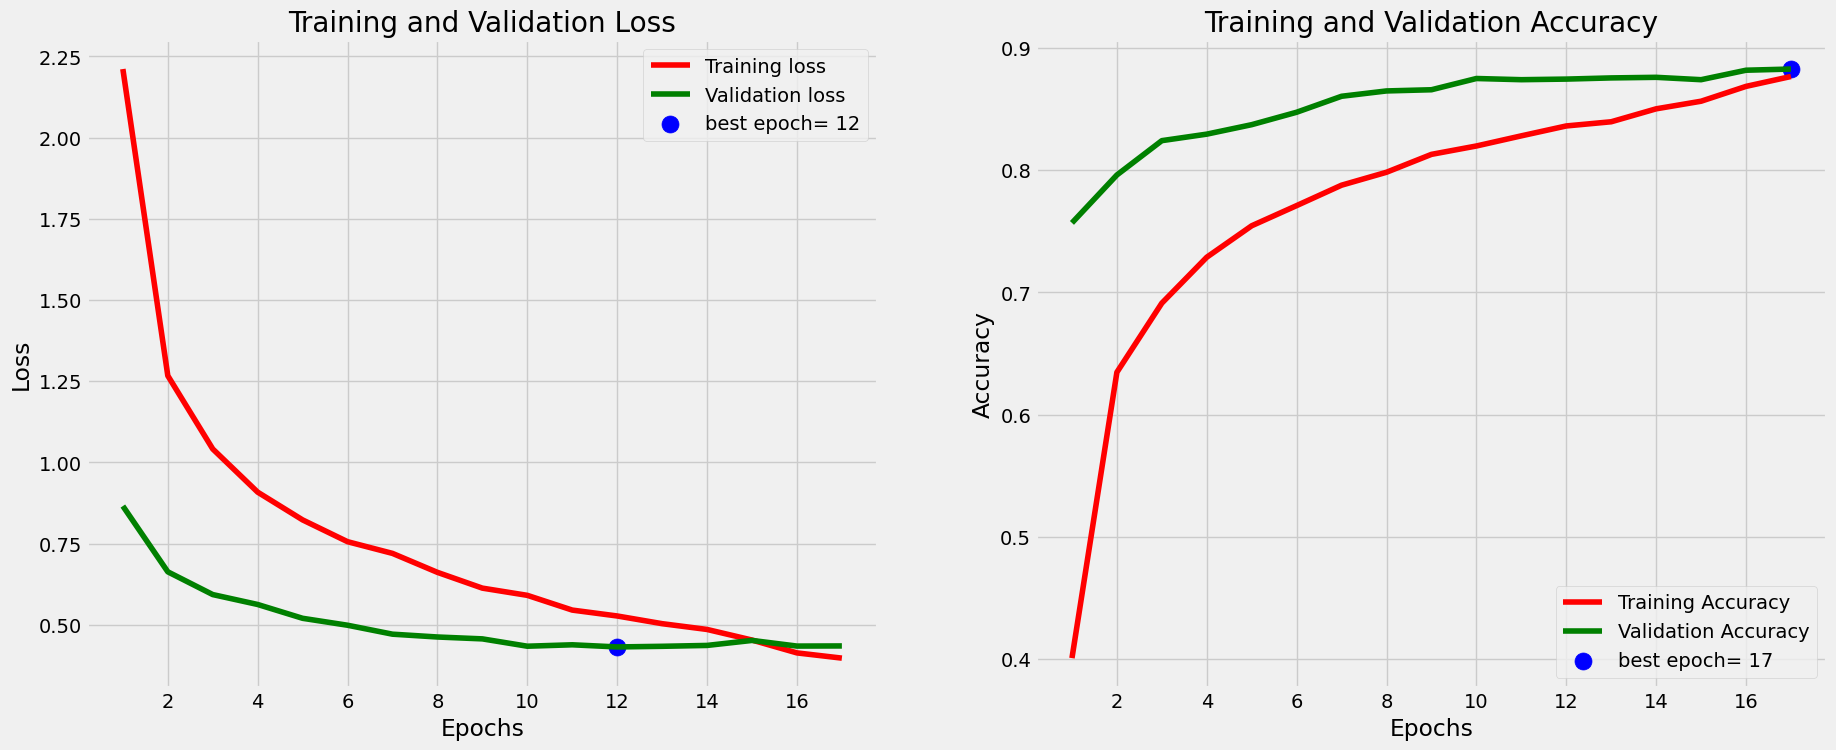

In [37]:
helperPlot2(im1)

We could see that training was halted at epoch 17 when validation loss cease to improve. However, with restore_best_weights = True parameter enabled for EarlyStopping callback, this ensures that the model weights are reverted back to those from the epoch with the best validation loss when training is stopped (i.e.12). This helps retain the best-performing model rather than the one at which training was halted.

<Figure size 2000x1000 with 0 Axes>

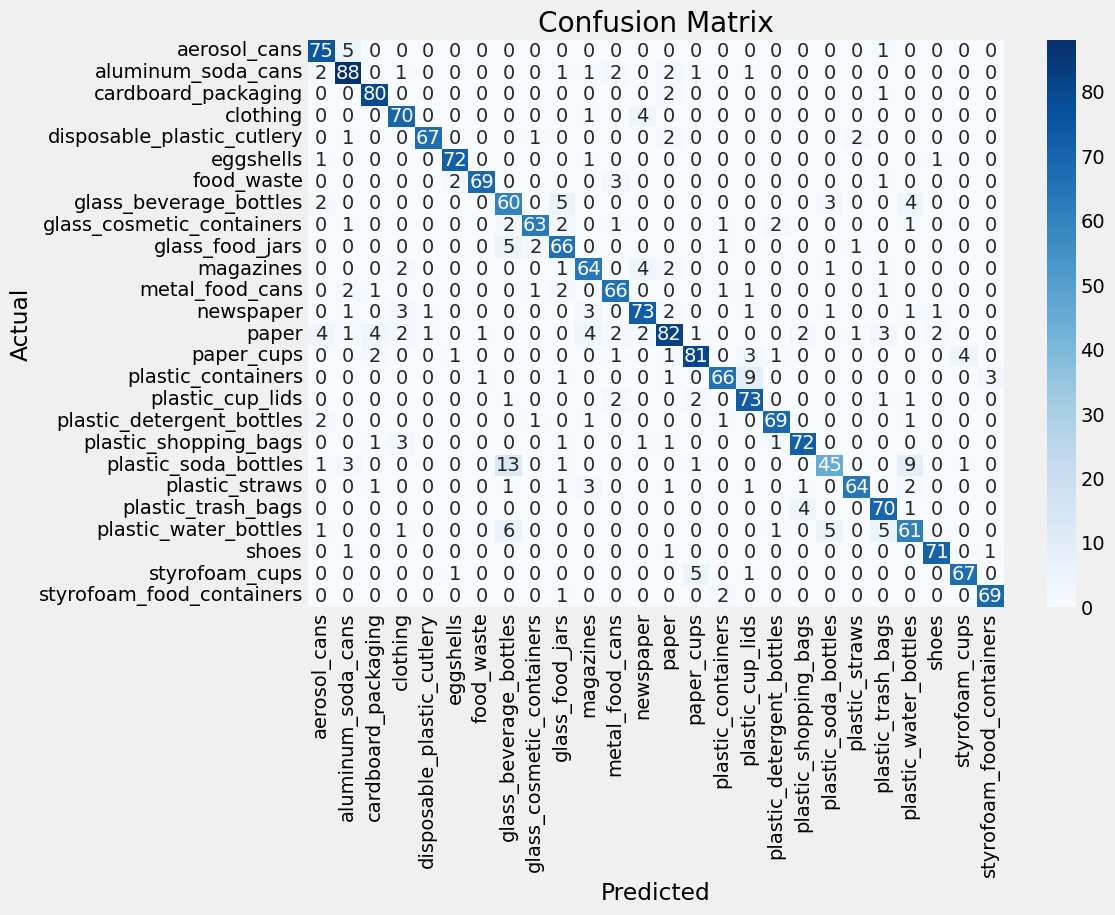

                            precision    recall  f1-score   support

              aerosol_cans       0.85      0.93      0.89        81
        aluminum_soda_cans       0.85      0.89      0.87        99
       cardboard_packaging       0.90      0.96      0.93        83
                  clothing       0.85      0.93      0.89        75
disposable_plastic_cutlery       0.97      0.92      0.94        73
                 eggshells       0.95      0.96      0.95        75
                food_waste       0.97      0.92      0.95        75
    glass_beverage_bottles       0.68      0.81      0.74        74
 glass_cosmetic_containers       0.93      0.86      0.89        73
           glass_food_jars       0.80      0.88      0.84        75
                 magazines       0.82      0.85      0.84        75
           metal_food_cans       0.86      0.88      0.87        75
                 newspaper       0.87      0.84      0.85        87
                     paper       0.85      0.73

In [59]:
plotCMHM(true_labels,y_pred_classes2,test_generator)

The values along the diagonal of the heatmap is the number of True Positive Cases.  Any Number along the horizontal row for a class is the number of False Negative predicted for that row.  For the same class, the false positive number could be found along the vertical axis.  We could see that the model has a tendency to misclassify glass beverage bottles and plastic water bottles as plastic soda bottles , plastic containers with plastic cups

In [11]:
num_layers = 2  # Number of hidden layers
units = [480, 480]   # Number of units in each hidden layer
num_batchnorm_layers = 2  # Number of Batch Normalization layers
num_dropout_layers = 2     # Number of Dropout layers
dropout_rates = [0.2, 0.3]  # Dropout rates for each Dropout layer
learning_rate = 0.0001      # Learning rate

# Create the final model based on hyperparameter tuning results
final_model0 = create_final_model3(num_layers=num_layers,
                                  units=units,
                                  num_batchnorm_layers=num_batchnorm_layers,
                                  num_dropout_layers=num_dropout_layers,
                                  dropout_rates=dropout_rates,
                                  learning_rate=learning_rate)

In [12]:
fm0 = final_model0.fit(train_generator,validation_data = val_generator,
                       epochs = 40, callbacks = [EarlyStopping(
    monitor='val_loss',  
    patience=5,           
    mode='min',           
    verbose=1,
    restore_best_weights = True             
),ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6,
    verbose=1)])

#time taken 79 min, train acc = 90.46%, val acc = 89.15%, test acc = 90.01%, best 23 epochs

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 166s 264ms/step - accuracy: 0.2857 - loss: 2.7960 - val_accuracy: 0.7632 - val_loss: 0.7951 - learning_rate: 1.0000e-04
Epoch 2/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 166s 274ms/step - accuracy: 0.6333 - loss: 1.2567 - val_accuracy: 0.8150 - val_loss: 0.6136 - learning_rate: 1.0000e-04
Epoch 3/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 166s 274ms/step - accuracy: 0.7085 - loss: 0.9647 - val_accuracy: 0.8339 - val_loss: 0.5443 - learning_rate: 1.0000e-04
Epoch 4/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 154s 255ms/step - accuracy: 0.7599 - loss: 0.7897 - val_accuracy: 0.8416 - val_loss: 0.5150 - learning_rate: 1.0000e-04
Epoch 5/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 154s 256ms/step - accuracy: 0.7736 - loss: 0.7261 - val_accuracy: 0.8455 - val_loss: 0.4802 - learning_rate: 1.0000e-04
Epoch 6/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 154s 256ms/step - accuracy: 0.7986 - loss: 0.6759 - val_accuracy: 0.8605 - val_loss: 0.4620 - learning_rate: 1.0000e-04
Epoch 7/40
603/603 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
test_loss, test_accuracy = final_model0.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

true_labels = test_generator.classes 

# Get predicted class indices
y_pred_classes0 = np.argmax(final_model0.predict(test_generator), axis=1)

/home/ec2-user/.local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.9203 - loss: 0.3613
Test Loss: 0.3847931921482086, Test Accuracy: 0.9007744193077087
130/130 ━━━━━━━━━━━━━━━━━━━━ 27s 195ms/step


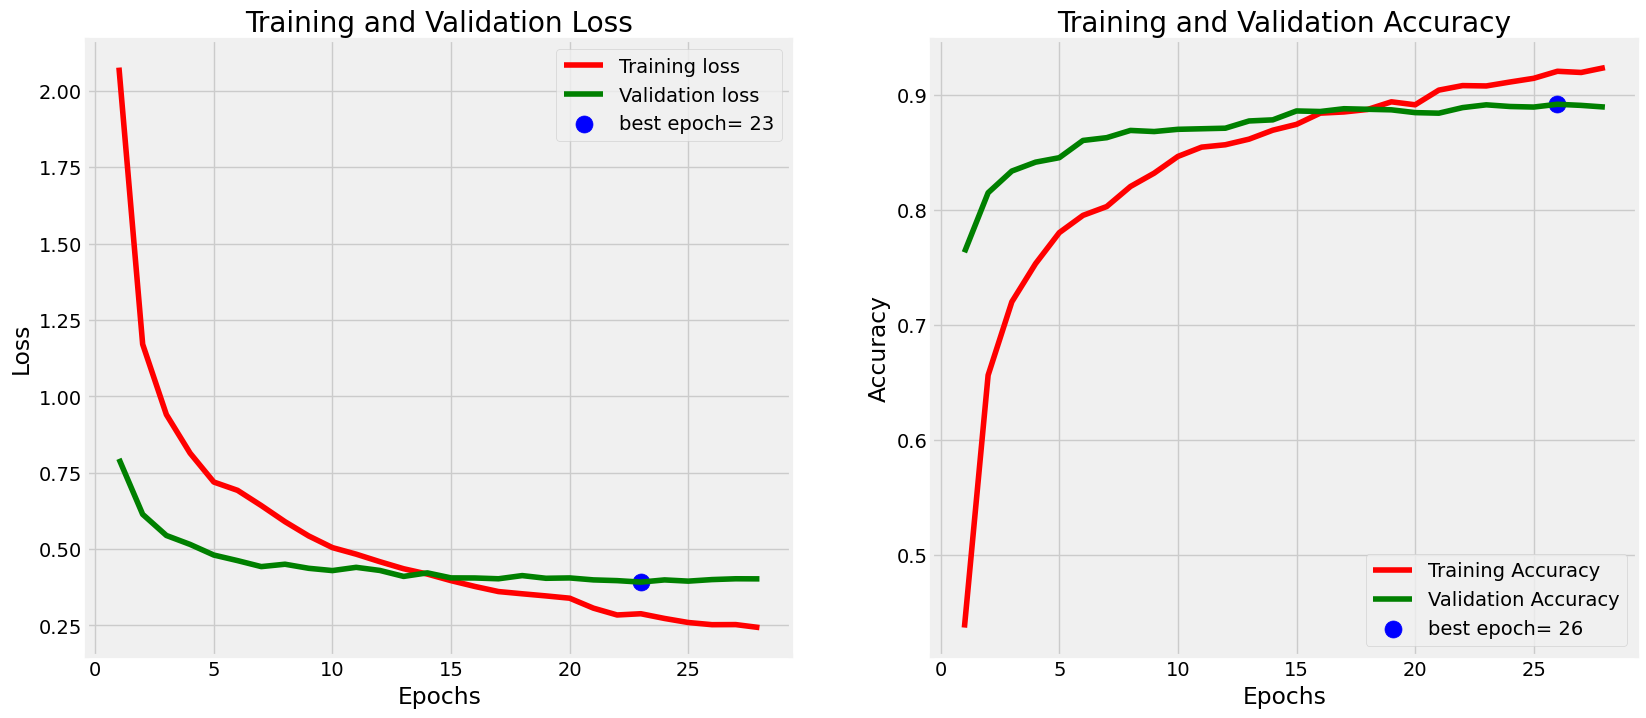

In [18]:
helperPlot2(fm0)

<Figure size 2000x1000 with 0 Axes>

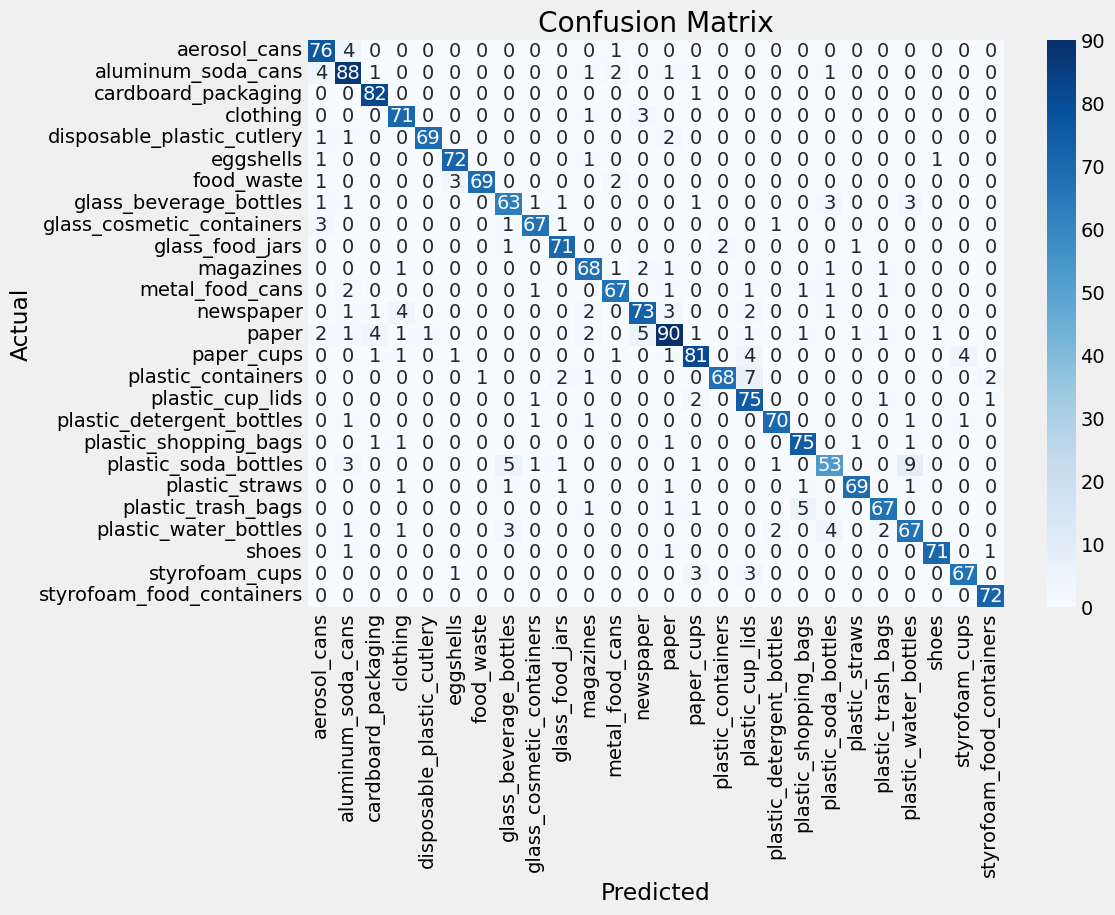

                            precision    recall  f1-score   support

              aerosol_cans       0.85      0.94      0.89        81
        aluminum_soda_cans       0.85      0.89      0.87        99
       cardboard_packaging       0.91      0.99      0.95        83
                  clothing       0.88      0.95      0.91        75
disposable_plastic_cutlery       0.99      0.95      0.97        73
                 eggshells       0.94      0.96      0.95        75
                food_waste       0.99      0.92      0.95        75
    glass_beverage_bottles       0.85      0.85      0.85        74
 glass_cosmetic_containers       0.93      0.92      0.92        73
           glass_food_jars       0.92      0.95      0.93        75
                 magazines       0.87      0.91      0.89        75
           metal_food_cans       0.91      0.89      0.90        75
                 newspaper       0.88      0.84      0.86        87
                     paper       0.87      0.80

In [60]:
plotCMHM(true_labels,y_pred_classes0,test_generator)

In [20]:
final_model0.save('Nb016_0.keras')

with open('Nb016_0.pkl', 'wb') as file:  
    pickle.dump(final_model0, file)

Next we create a customer function that allows us to further finetune the model.  During initial training, all layers of the pre-trained model were  "frozen," meaning their weights are not updated during training. Typically, the initial layers, which capture generic features (like edges in images), remain unchanged. 

The later layers, which capture more specific features relevant to the original task, are be unfrozen and adjusted to better suit our use. For this reason we shall specify a number of layers in a list that will be iterated through.  We will call ModelCheckPoint to save the best model fetching the highest validation accuracy for each specified number of unfrozen layers

In [24]:
# Function to fine-tune the model and return validation accuracy
def fine_tune_and_evaluate(final_model, train_generator, val_generator, layers_to_unfreeze,base_learning_rate):
    # Unfreeze specified layers
    for layer in final_model.layers[0].layers[-layers_to_unfreeze:]:
        layer.trainable = True

    checkpoint_filename = f'best_model_B016_Finetuned_layers_{layers_to_unfreeze}.keras'
    # Recompile the model with a lower learning rate for fine-tuning
    final_model.compile(optimizer=Adam(learning_rate=0.1*base_learning_rate),  
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])
    
    # Continue training with fine-tuning
    fm_finetune = final_model.fit(train_generator,
                                    validation_data=val_generator,
                                    epochs=20,
                                    callbacks=
                                    [EarlyStopping(
                                        monitor='val_loss',  
                                        patience=5,           
                                        mode='min',           
                                        verbose=1, restore_best_weights=True), 
                                    ReduceLROnPlateau(
                                        monitor='val_loss', 
                                        factor=0.5, 
                                        patience=3, 
                                        min_lr=1e-6,
                                        verbose=1),
                                    ModelCheckpoint(checkpoint_filename, 
                                        monitor='val_accuracy', 
                                        save_best_only=True, 
                                        mode='max', 
                                        verbose=1)],
                                    verbose=0)  # Set verbose to 0 to suppress output

    return fm_finetune.history['val_accuracy'][-1]  # Return last validation accuracy

In [25]:
results0 = {}  #to store the best results in a dictionary for easier reference.

# Iterate over different values of i (number of layers to unfreeze)
for i in [5, 10, 15, 20,25]:  # Adjust these values as needed
    val_accuracy = fine_tune_and_evaluate(final_model0, train_generator, val_generator, i,0.0001)
    results0[i] = val_accuracy
    print(f"Unfreezing {i} layers: Validation Accuracy = {val_accuracy:.4f}")

# Print summary of results
print("Fine-tuning results:")
for layers_unfrozen, accuracy in results0.items():
    print(f"Layers unfrozen: {layers_unfrozen}, Validation Accuracy: {accuracy:.4f}")

    #runtime 296 min, best # lkayers: 10, val acc 89.78%, 90.07%, 


Epoch 1: val_accuracy improved from -inf to 0.88329, saving model to best_model_B016_Finetuned_layers_5.keras

Epoch 2: val_accuracy did not improve from 0.88329

Epoch 3: val_accuracy improved from 0.88329 to 0.88523, saving model to best_model_B016_Finetuned_layers_5.keras

Epoch 4: val_accuracy did not improve from 0.88523

Epoch 5: val_accuracy improved from 0.88523 to 0.88620, saving model to best_model_B016_Finetuned_layers_5.keras

Epoch 6: val_accuracy improved from 0.88620 to 0.88668, saving model to best_model_B016_Finetuned_layers_5.keras

Epoch 7: val_accuracy did not improve from 0.88668

Epoch 8: val_accuracy did not improve from 0.88668

Epoch 9: val_accuracy did not improve from 0.88668

Epoch 10: val_accuracy improved from 0.88668 to 0.88910, saving model to best_model_B016_Finetuned_layers_5.keras

Epoch 11: val_accuracy did not improve from 0.88910

Epoch 12: val_accuracy improved from 0.88910 to 0.89104, saving model to best_model_B016_Finetuned_layers_5.keras

Epo

In [51]:
loaded_model = load_model('best_model_B016_Finetuned_layers_10.keras')

In [52]:
test_loss, test_accuracy = loaded_model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Get predicted class indices
y_pred_classesLM = np.argmax(loaded_model.predict(test_generator), axis=1)

130/130 ━━━━━━━━━━━━━━━━━━━━ 43s 298ms/step - accuracy: 0.9222 - loss: 0.3649
Test Loss: 0.3890775442123413, Test Accuracy: 0.907066822052002
130/130 ━━━━━━━━━━━━━━━━━━━━ 45s 326ms/step


<Figure size 2000x1000 with 0 Axes>

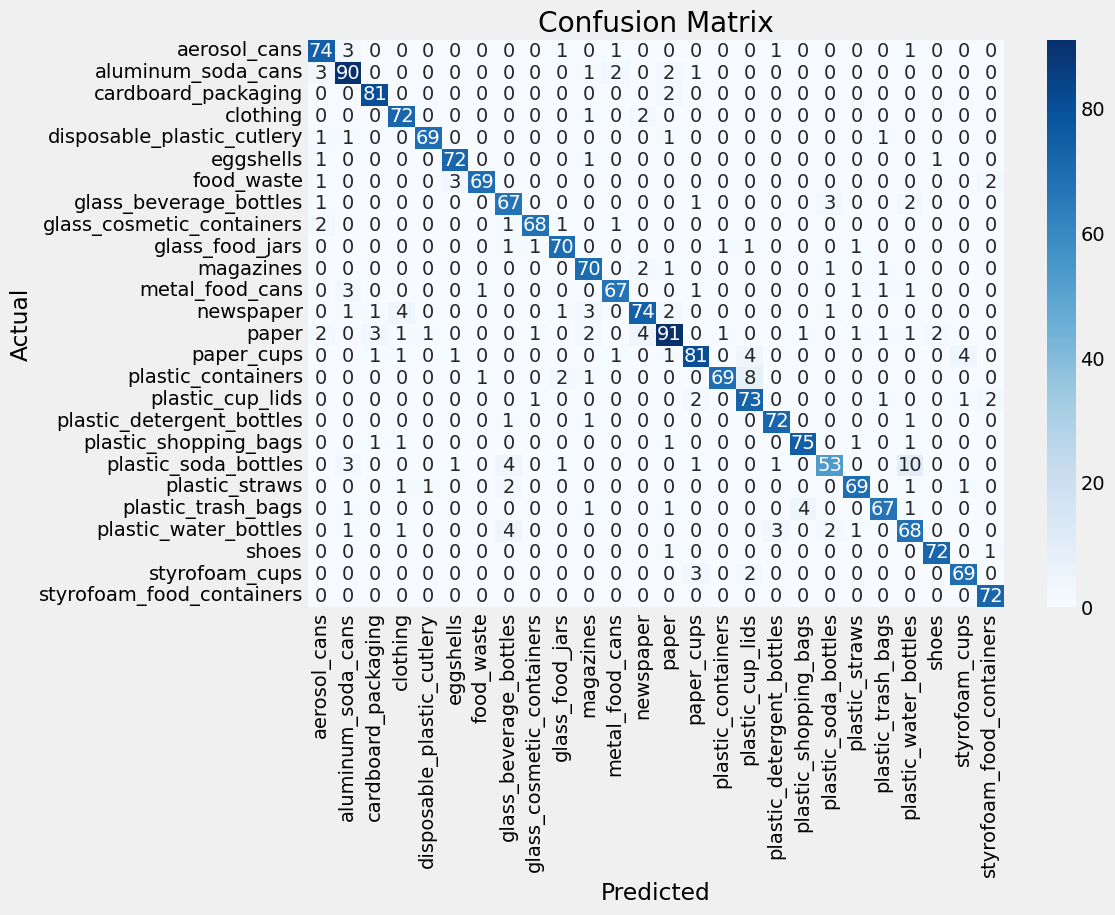

                            precision    recall  f1-score   support

              aerosol_cans       0.87      0.91      0.89        81
        aluminum_soda_cans       0.87      0.91      0.89        99
       cardboard_packaging       0.93      0.98      0.95        83
                  clothing       0.89      0.96      0.92        75
disposable_plastic_cutlery       0.97      0.95      0.96        73
                 eggshells       0.94      0.96      0.95        75
                food_waste       0.97      0.92      0.95        75
    glass_beverage_bottles       0.84      0.91      0.87        74
 glass_cosmetic_containers       0.96      0.93      0.94        73
           glass_food_jars       0.92      0.93      0.93        75
                 magazines       0.86      0.93      0.90        75
           metal_food_cans       0.93      0.89      0.91        75
                 newspaper       0.90      0.85      0.88        87
                     paper       0.88      0.81

In [61]:
plotCMHM(true_labels,y_pred_classesLM,test_generator)

For the section below, we will use Keras hyperband tuner to determine the set of hyperparameters that achieve the highest validation accuracy. 

Hyperparameter tuning for various components are incorporated:
-The number of dense layers,
-The number of neurons in those layers,
-Regularization methods,
-Dropout rates,
-Optimizer types,
-Learning rates

In [43]:
#Tuning number of hidden layers, neurons, number of drop out layers and BatchNormalization
def build_model(hp):
    model = Sequential()
    
    # Use EfficientNetB0 as the base model
    # Use EfficientNetB0 as the base model
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False  

    model.add(base_model)
    
    # Flatten the output from the base model
    model.add(GlobalAveragePooling2D())

    
# Tune the number of dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=4)
    
    # Add specified number of dense layers with tunable neurons and regularization
    for i in range(num_dense_layers):
        neurons = hp.Int(f'neurons_{i}', min_value=224, max_value=512, step=32)
        
        # Choose regularization type
        regularization_type = hp.Choice(f'regularization_{i}', ['none', 'l1', 'l2'])
        if regularization_type == 'l1':
            reg = l1(0.01)  # You can tune this value as well
        elif regularization_type == 'l2':
            reg = l2(0.01)  # You can tune this value as well
        else:
            reg = None
        
        model.add(Dense(neurons, activation='relu', kernel_regularizer=reg))

        model.add(BatchNormalization())
        
        model.add(Dropout(rate=hp.Float(f"dropout_rate_{i}", min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(len(df['label'].unique()), activation='softmax'))  # Adjust based on your categories
    
    # Choose optimizer and learning rate
    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    


In [44]:
# Instantiate the Hyperband tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='ec2_new_dir',
    project_name='ec2_new__efficientnetb0'
)

In [45]:
# Assuming you have your training data ready (x_train, y_train)
tuner.search(train_generator, epochs=50, validation_data=val_generator)

#runtime : 641 min, best val acc 88.2%

Trial 30 Complete [00h 51m 53s]
val_accuracy: 0.8731234669685364

Best val_accuracy So Far: 0.8823244571685791
Total elapsed time: 10h 41m 01s


In [46]:
best_model1 = tuner.get_best_models(num_models=1)[0]
best_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │       409,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         8,346 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,469,117 (17.05 MB)

 Trainable params: 418,906 (1.60 MB)

 Non-trainable params: 4,050,211 (15.45 MB)

In [48]:
# Function to fine-tune the model and return validation accuracy
def fine_tune_and_evaluate(final_model, train_generator, val_generator, layers_to_unfreeze,base_learning_rate):
    # Unfreeze specified layers
    for layer in final_model.layers[0].layers[-layers_to_unfreeze:]:
        layer.trainable = True

    checkpoint_filename = f'best_tuned_model2_B016_Finetuned_layers_{layers_to_unfreeze}.keras'
    # Recompile the model with a lower learning rate for fine-tuning
    final_model.compile(optimizer=Adam(learning_rate=0.1*base_learning_rate),  
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])
    
    # Continue training with fine-tuning
    fm_finetune = final_model.fit(train_generator,
                                    validation_data=val_generator,
                                    epochs=20,
                                    callbacks=
                                    [EarlyStopping(
                                        monitor='val_loss',  
                                        patience=5,           
                                        mode='min',           
                                        verbose=1, restore_best_weights=True), 
                                    ReduceLROnPlateau(
                                        monitor='val_loss', 
                                        factor=0.5, 
                                        patience=3, 
                                        min_lr=1e-6,
                                        verbose=1),
                                    ModelCheckpoint(checkpoint_filename, 
                                        monitor='val_accuracy', 
                                        save_best_only=True, 
                                        mode='max', 
                                        verbose=1)],
                                    verbose=0)  # Set verbose to 0 to suppress output

    return fm_finetune.history['val_accuracy'][-1]  # Return last validation accuracy

In [49]:
results0 = {}

# Iterate over different values of i (number of layers to unfreeze)
for i in [5, 10, 15, 20,25]:  # Adjust these values as needed
    val_accuracy = fine_tune_and_evaluate(best_model1, train_generator, val_generator, i,0.0001)
    results0[i] = val_accuracy
    print(f"Unfreezing {i} layers: Validation Accuracy = {val_accuracy:.4f}")

# Print summary of results
print("Fine-tuning results:")
for layers_unfrozen, accuracy in results0.items():
    print(f"Layers unfrozen: {layers_unfrozen}, Validation Accuracy: {accuracy:.4f}")

    #412 min, best # layers unfrozen: 25, val acc = 89.9%, test acc = 91.14%


Epoch 1: val_accuracy improved from -inf to 0.86877, saving model to best_tuned_model2_B016_Finetuned_layers_5.keras

Epoch 2: val_accuracy did not improve from 0.86877

Epoch 3: val_accuracy improved from 0.86877 to 0.87022, saving model to best_tuned_model2_B016_Finetuned_layers_5.keras

Epoch 4: val_accuracy improved from 0.87022 to 0.87312, saving model to best_tuned_model2_B016_Finetuned_layers_5.keras

Epoch 5: val_accuracy improved from 0.87312 to 0.87361, saving model to best_tuned_model2_B016_Finetuned_layers_5.keras

Epoch 6: val_accuracy improved from 0.87361 to 0.87603, saving model to best_tuned_model2_B016_Finetuned_layers_5.keras

Epoch 7: val_accuracy improved from 0.87603 to 0.87748, saving model to best_tuned_model2_B016_Finetuned_layers_5.keras

Epoch 8: val_accuracy improved from 0.87748 to 0.87845, saving model to best_tuned_model2_B016_Finetuned_layers_5.keras

Epoch 9: val_accuracy improved from 0.87845 to 0.87893, saving model to best_tuned_model2_B016_Finetune

We can either save our models as a pickle file or Keras file

In [57]:
with open('tfm1.pkl', 'wb') as file:  
    pickle.dump(loaded_model, file)
